## Pyłek (ang. Flyweight)

**Typ**: strukturalny \
**Zakres**: obiektowy

<div style="border: solid 1px;padding: 20px;text-align: center">
    Wzorzec <b>pyłek</b> używa współdzielenia, aby efektywnie obsługiwać duże ilości małych obiektów.
</div>

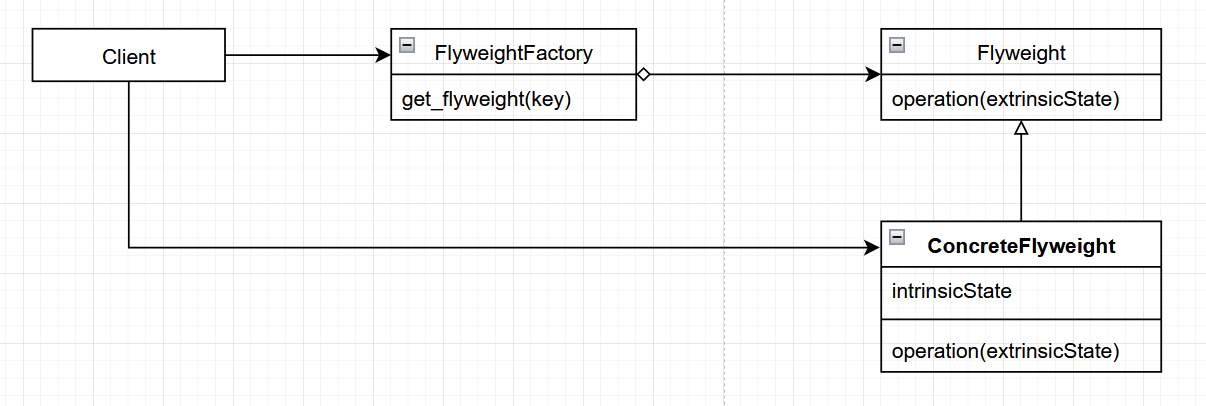

### Problem - ogromna liczba obiektów

Tworzysz edytor tekstu. Każdy znak na ekranie to osobny obiekt z czcionką, rozmiarem i pozycją. 

Dokument ma 100 000 znaków. To oznacza **100 000 obiektów** w pamięci!

### Naiwne podejście - każdy znak = nowy obiekt

In [ ]:
class Character:
    def __init__(self, char, font, size, x, y):
        self.char = char    # Znak (np. 'A')
        self.font = font    # Czcionka (np. 'Arial')
        self.size = size    # Rozmiar (np. 12)
        self.x = x          # Pozycja X
        self.y = y          # Pozycja Y
    
    def display(self):
        print(f"'{self.char}' ({self.font}, {self.size}pt) na ({self.x}, {self.y})")

In [ ]:
# Tekst: "AAA"
text = [
    Character('A', 'Arial', 12, 0, 0),
    Character('A', 'Arial', 12, 10, 0),  # To samo A!
    Character('A', 'Arial', 12, 20, 0),  # Znowu to samo A!
]

for char in text:
    char.display()

**Problem:**
- Trzy litery 'A' = **3 osobne obiekty**
- Każdy obiekt zawiera te same dane: `char='A'`, `font='Arial'`, `size=12`
- W dokumencie 10 000 liter 'A' = **10 000 duplikatów tych samych danych**!
- **Ogromne marnotrawstwo pamięci**

Co się powtarza? **Znak, czcionka, rozmiar** \
Co jest unikalne? **Pozycja (x, y)**

### Analiza - podział stanu

Kluczowe pytanie: **Co jest wspólne dla wielu obiektów?** **Co jest unikalne?**

**Stan wewnętrzny (intrinsic)** - wspólny dla wielu obiektów:
- Znak (`char`)
- Czcionka (`font`)
- Rozmiar (`size`)

**Stan zewnętrzny (extrinsic)** - unikalny dla każdego obiektu:
- Pozycja X (`x`)
- Pozycja Y (`y`)

**Pomysł:** Zamiast tworzyć 10 000 obiektów dla 'A', stwórz **1 obiekt** i **użyj go 10 000 razy**!

### Rozwiązanie - wzorzec Pyłek

**Idea:** Wydziel stan wewnętrzny (wspólny) do osobnego obiektu i **współdziel** go między wieloma użyciami.

### Krok 1: Pyłek - tylko stan wewnętrzny

In [ ]:
class CharacterFlyweight:
    """Pyłek - zawiera tylko stan wewnętrzny (współdzielony)"""
    def __init__(self, char, font, size):
        self.char = char    # Stan wewnętrzny
        self.font = font    # Stan wewnętrzny
        self.size = size    # Stan wewnętrzny
    
    def display(self, x, y):
        # Stan zewnętrzny (x, y) przekazywany z zewnątrz!
        print(f"'{self.char}' ({self.font}, {self.size}pt) na ({x}, {y})")

**Kluczowa zmiana:**
- Pyłek **NIE przechowuje** pozycji (x, y) (**stan zewnętrzny**)
- Pozycja **przekazywana** do metody `display(x, y)` z zewnątrz
- Dzięki temu **jeden obiekt pyłka** może być używany w wielu miejscach

### Krok 2: Fabryka Pyłków - zarządzanie współdzieleniem

Fabryka pyłków będzie takim cachem dla pyłków. Jeżeli pyłek o zadanym stanie wewnętrznym (key) nie istnieje, tworzymy go i dodajemy do pooli. W przeciwnym razie wyciągamy z pooli już istniejący pyłek.

In [ ]:
class FlyweightFactory:
    """Zarządza poolem współdzielonych pyłków"""
    def __init__(self):
        self._flyweights = {}  # Pool pyłków
    
    def get_flyweight(self, char, font, size):
        # Klucz unikalny dla kombinacji stanu wewnętrznego
        key = (char, font, size)
        
        if key not in self._flyweights:
            # Tworzymy nowy pyłek tylko jeśli nie istnieje
            self._flyweights[key] = CharacterFlyweight(char, font, size)
            print(f"Tworzę nowy pyłek: {key}")
        else:
            print(f"Używam istniejącego pyłka: {key}")
        
        return self._flyweights[key]
    
    def count(self):
        return len(self._flyweights)

**Fabryka gwarantuje:**
- Dla tej samej kombinacji (`'A'`, `'Arial'`, `12`) zawsze zwraca **ten sam obiekt**
- Nowy pyłek tworzony tylko gdy potrzebny
- **Pool pyłków** minimalizuje liczbę obiektów w pamięci

### Krok 3: Użycie - współdzielenie w akcji

In [ ]:
factory = FlyweightFactory()

# Tekst: "AAA"
# Każda litera ma swoją pozycję (stan zewnętrzny)
text = [
    (factory.get_flyweight('A', 'Arial', 12), 0, 0),   # Pierwsza A
    (factory.get_flyweight('A', 'Arial', 12), 10, 0),  # Druga A - ten sam pyłek!
    (factory.get_flyweight('A', 'Arial', 12), 20, 0),  # Trzecia A - ten sam pyłek!
]

print("\nWyświetlanie tekstu:")
for flyweight, x, y in text:
    flyweight.display(x, y)

print(f"\nLiczba znaków: {len(text)}")
print(f"Liczba pyłków w pamięci: {factory.count()}")

**Wynik:**
- 3 znaki 'A' → **1 obiekt pyłka** zamiast 3!
- Oszczędność: 66% pamięci

### Przykład 2 - większy tekst

In [ ]:
factory = FlyweightFactory()

# Tekst: "HELLO WORLD"
message = "HELLO WORLD"
text = []

for i, char in enumerate(message):
    flyweight = factory.get_flyweight(char, 'Arial', 12)
    text.append((flyweight, i * 10, 0))

print(f"\nLiczba znaków: {len(message)}")
print(f"Liczba pyłków w pamięci: {factory.count()}")
print(f"Oszczędność: {(1 - factory.count() / len(message)) * 100:.1f}%")

**"HELLO WORLD"** (11 znaków):
- Bez Pyłka: **11 obiektów**
- Z Pyłkiem: **8 obiektów** (H, E, L, O, spacja, W, R, D)
- Litera 'L' powtarza się 3 razy → **1 pyłek**, 3 użycia!

## Struktura wzorca

**Elementy wzorca Pyłek:**


1. **Flyweight** - `CharacterFlyweight`
   - Przechowuje **stan wewnętrzny** (współdzielony)
   - Metody przyjmują **stan zewnętrzny** jako parametry
   - **Niezmienny** (immutable) - ważne dla współdzielenia! (po wyciągnięciu z fabryki nie powinniśmy móc modyfikować jego stanu wewnętrznego, w przeciwnym razie w systemie będą krążyły pyłki, których formalnie nie mają swojej reprezentacji w fabryce. Najprościej osiągnąć to za pomocą dataclass i parametru frozen=True).

2. **FlyweightFactory** - `FlyweightFactory`
   - Zarządza **poolem pyłków**
   - Tworzy nowe pyłki tylko gdy konieczne
   - Gwarantuje współdzielenie


3. **Client**
   - Przechowuje **stan zewnętrzny**
   - Wywołuje metody pyłka, przekazując stan zewnętrzny

## Przykład 3 - drzewa w grze

In [ ]:
# ════════════════════════════════════════════════════════════
# Pyłek - typ drzewa (stan wewnętrzny)
# ════════════════════════════════════════════════════════════
class TreeType:
    """Stan wewnętrzny: nazwa, kolor, tekstura (współdzielone)"""
    def __init__(self, name, color, texture):
        self.name = name
        self.color = color
        self.texture = texture
    
    def draw(self, x, y):
        # Stan zewnętrzny (x, y) przekazany z zewnątrz
        print(f"{self.name} ({self.color}) na ({x}, {y})")


# ════════════════════════════════════════════════════════════
# Fabryka Pyłków
# ════════════════════════════════════════════════════════════
class TreeFactory:
    def __init__(self):
        self._tree_types = {}
    
    def get_tree_type(self, name, color, texture):
        key = (name, color, texture)
        
        if key not in self._tree_types:
            self._tree_types[key] = TreeType(name, color, texture)
        
        return self._tree_types[key]
    
    def count(self):
        return len(self._tree_types)


# ════════════════════════════════════════════════════════════
# Drzewo w grze (stan zewnętrzny + referencja do pyłka)
# ════════════════════════════════════════════════════════════
class Tree:
    """Reprezentuje konkretne drzewo w grze"""
    def __init__(self, x, y, tree_type):
        self.x = x              # Stan zewnętrzny
        self.y = y              # Stan zewnętrzny
        self.tree_type = tree_type  # Referencja do pyłka
    
    def draw(self):
        self.tree_type.draw(self.x, self.y)


# ════════════════════════════════════════════════════════════
# Las - kolekcja drzew
# ════════════════════════════════════════════════════════════
class Forest:
    def __init__(self):
        self.trees = []
        self.factory = TreeFactory()
    
    def plant_tree(self, x, y, name, color, texture):
        tree_type = self.factory.get_tree_type(name, color, texture)
        tree = Tree(x, y, tree_type)
        self.trees.append(tree)
    
    def draw(self):
        for tree in self.trees:
            tree.draw()
    
    def stats(self):
        print(f"Drzew w lesie: {len(self.trees)}")
        print(f"Typów drzew (pyłków): {self.factory.count()}")
        print(f"Oszczędność: {(1 - self.factory.count() / len(self.trees)) * 100:.2f}%")

In [ ]:
# Las z 10 000 drzew, ale tylko 3 typy
forest = Forest()

# Sadzimy 10 000 drzew
for i in range(10000):
    if i % 3 == 0:
        forest.plant_tree(i, i, "Dąb", "zielony", "oak.png")
    elif i % 3 == 1:
        forest.plant_tree(i, i, "Sosna", "ciemnozielony", "pine.png")
    else:
        forest.plant_tree(i, i, "Brzoza", "biały", "birch.png")

forest.stats()

**Bez Pyłka:** 10 000 drzew = **10 000 obiektów** z nazwą, kolorem, teksturą

**Z Pyłkiem:** 10 000 drzew = **3 pyłki** (typy) + **10 000 pozycji** (x, y)

**Oszczędność:** 99.97% obiektów - 10000 pozycji (ale to i tak bardzo duża oszczędność)

## Kiedy używać wzorca Pyłek?

Wzorzec Pyłek stosuj gdy **WSZYSTKIE** warunki są spełnione:

1. **Aplikacja używa OGROMNEJ liczby obiektów**
   - Tysiące, miliony obiektów
   - Zużycie pamięci jest problemem

2. **Większość unikalnego stanu obiektu może być zewnętrzna**

   - Stan można wydzielić na wewnętrzny (współdzielony) i zewnętrzny (unikalny)
   - jeżeli większość jest WEWNĘTRZNA i UNIKALNA, to niewiele zaoszczędzamy, bo i tak większość pyłków musi zostać stworzona przez fabrykę

4. **Można zastąpić wiele obiektów mniejszą liczbą współdzielonych**
   - Wiele obiektów ma identyczny stan wewnętrzny
   - Różnią się tylko stanem zewnętrznym

5. **Tożsamość obiektu nie jest ważna**
   - Klient nie potrzebuje unikalnych obiektów
   - Może współdzielić obiekty

**Przykłady praktyczne:**
- Znaki w edytorze tekstu (10 000+ znaków, ~100 unikalnych pyłków)
- Drzewa/budynki w grach (miliony obiektów, dziesiątki typów)
- Cząsteczki w symulacjach fizycznych
- Ikony/sprites w UI
- Połączenia w poolach połączeń

## Kluczowe zasady

**1. Pyłki muszą być NIEZMIENNE (immutable)**

```python
# ❌ ŹLE - pyłek zmienny
flyweight = factory.get_flyweight('A', 'Arial', 12)
flyweight.size = 14  # Zmienia dla WSZYSTKICH użyć!

# ✅ DOBRZE - stan zewnętrzny przekazywany do metod
flyweight.display(x, y)  # Pyłek pozostaje niezmienny
```

**2. Fabryka gwarantuje współdzielenie**

```python
f1 = factory.get_flyweight('A', 'Arial', 12)
f2 = factory.get_flyweight('A', 'Arial', 12)
assert f1 is f2  # Ten sam obiekt!
```

**3. Klient zarządza stanem zewnętrznym**

```python
# Klient przechowuje pozycje (stan zewnętrzny)
text = [
    (flyweight_A, 0, 0),
    (flyweight_A, 10, 0),  # Ten sam pyłek, inna pozycja
]
```

## Podsumowanie

Wzorzec Pyłek:
- ✅ **Drastycznie redukuje zużycie pamięci** (99%+ oszczędności)
- ✅ **Współdzieli obiekty** zamiast tworzyć duplikaty
- ✅ **Oddziela stan** na wewnętrzny (współdzielony) i zewnętrzny (unikalny)
- ⚠️ **Zwiększa złożoność** - trzeba zarządzać stanem zewnętrznym
- ⚠️ **Wymaga niezmienności** pyłków
- ⚠️ **Ma sens tylko dla OGROMNEJ liczby obiektów**

**Kluczowa idea:**
> Zamiast tysiąca kopii tego samego, miej **jedną kopię użytą tysiąc razy**

**Struktura:**
- **Flyweight** - stan wewnętrzny (współdzielony), metody przyjmują stan zewnętrzny
- **FlyweightFactory** - pool pyłków, gwarantuje współdzielenie
- **Client** - zarządza stanem zewnętrznym, używa pyłków

**Formuła:**
```python
# Stan wewnętrzny → Pyłek (współdzielony)
flyweight = factory.get_flyweight(intrinsic_state)

# Stan zewnętrzny → Przekazywany do metod
flyweight.operation(extrinsic_state)
```

**Istota wzorca:**
- **Podział stanu:** wewnętrzny (współdzielony) vs zewnętrzny (unikalny)
- **Współdzielenie:** 10 000 obiektów → 10 pyłków + 10 000 stanów zewnętrznych
- **Oszczędność:** Mniej obiektów = mniej pamięci